# Стоимость поддержанного автомобиля

Предсказание стоимости автомобиля на вторичном рынке.

## Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

Целью проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

### Описание данных

Наша задача - разработать модель для предсказания стоимости продажи автомобиля на вторичном рынке.

train.csv - информация о продажах автомобилей с аукционов, которые будут использоваться в качестве обучающих данных.

test.csv - информация о продажах автомобилей с аукционов, которые будут использоваться в качестве тестовых данных.

sample_submission.csv - файл предсказаний в правильном формате.

vin - идентификатор каждого автомобиля в тестовом наборе.

sellingprice - Целевой признак.

'year' - год производства

'make' - производитель

'model' - модель

'trim' - модификация

'body' - тип кузова

'transmission' - тип КПП

'vin' - идентификатор (вин)

'state' - штат регистрации

'condition' - состояние по шкале (1-5)

'odometer' - пробег

'color' - цвет кузова

'interior' - цвет интерьера

'seller' - продавец

'sellingprice' - стоимость продажи

'saledate' - дата продажи

#### Примечаниe:

Для оценки качества моделей применяем метрику MAPE.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [2]:
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install vininfo

In [4]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

from vininfo import Vin

In [5]:
!pip install -q lightgbm==3.3.5
import lightgbm as lgb

In [6]:
!pip install -q python-Levenshtein
from Levenshtein import distance as lev

In [7]:
plt.style.use('fivethirtyeight')

In [8]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [9]:
plt_params = {'axes.titlesize': '16',
              'axes.labelsize': '14',
              'axes.spines.left': True,
              'axes.spines.bottom': True,
              'axes.spines.right': False,
              'axes.spines.top': False,
              'xtick.labelsize': '12',
              'ytick.labelsize': '12',
              'legend.fontsize': '12',
              'lines.linewidth': '2.0'}

plt.rcParams.update(plt_params)

## Загрузка и анализ данных

In [10]:
df = pd.read_csv('C:/Users/Family/Downloads/used-cars-price-prediction-22ds/train.csv')
test = pd.read_csv('C:/Users/Family/Downloads/used-cars-price-prediction-22ds/test.csv')

In [11]:
def describe_df(df):
    display(df.head())
    print('-----------------------------------------------------------------------------------------------')
    display(df.info())
    print('-----------------------------------------------------------------------------------------------')
    display(df.describe())
    print('-----------------------------------------------------------------------------------------------')
    display(f'Количество дубликатов: {df.duplicated().sum()}')

In [12]:
describe_df(df)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


-----------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memo

None

-----------------------------------------------------------------------------------------------


,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


-----------------------------------------------------------------------------------------------


'Количество дубликатов: 0'

In [14]:
pip install --upgrade matplotlib

  Using cached matplotlib-3.8.0-cp39-cp39-win_amd64.whl (7.6 MB)
     ---------------------------------------- 2.1/2.1 MB 395.4 kB/s eta 0:00:00
  Using cached contourpy-1.1.1-cp39-cp39-win_amd64.whl (435 kB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\Family\\anaconda3\\envs\\ds_practicum_env\\Lib\\site-packages\\~atplotlib\\backends\\_backend_agg.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [18]:
pip install --upgrade hist


     -------------------------------------- 40.4/40.4 kB 324.2 kB/s eta 0:00:00
     ------------------------------------ 828.4/828.4 kB 396.6 kB/s eta 0:00:00


In [20]:
import seaborn as sns

AttributeError: 'SubplotSpec' object has no attribute 'is_first_col'

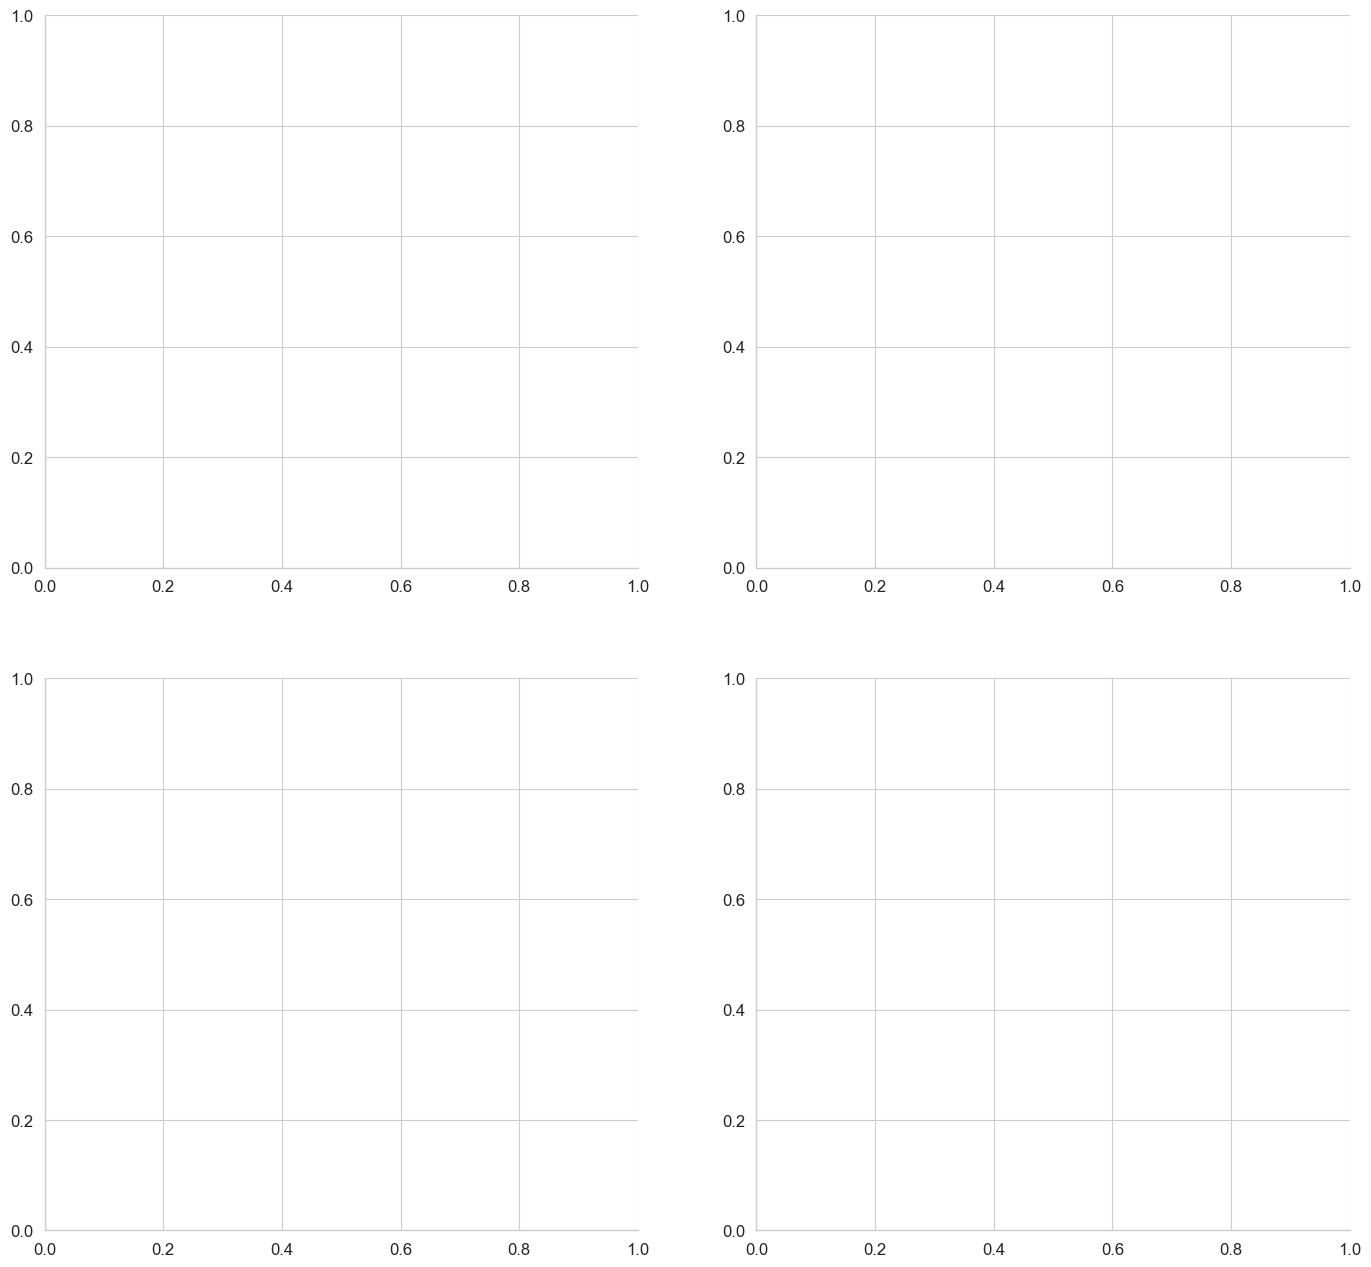

In [21]:
df.hist(figsize=(15,15), xrot=30)
plt.tight_layout()
plt.show()

In [ ]:
def lowercase(row):
    return str(row).lower()

In [ ]:
for column in df.select_dtypes('object').drop('saledate', axis=1).columns:
    df[column] = df[column].apply(lowercase)

In [ ]:
for column in df.select_dtypes('object').drop('saledate', axis=1).columns:
    test[column] = test[column].apply(lowercase)

In [ ]:
df.head()

In [ ]:
df.select_dtypes(['int64', 'float64']).columns

In [ ]:
sns.boxplot(df.year);

In [ ]:
len(df[df['year'] < 1997])

In [ ]:
df = df[df['year'] > 1997]

In [ ]:
sns.boxplot(df['condition']);

In [ ]:
sns.boxplot(df['sellingprice']);

In [ ]:
df[df['sellingprice'] > 200000]

Убираем данную строку из дата сета, как аномальную

In [ ]:
df = df[df['sellingprice'] < 200000]

In [ ]:
df[df['sellingprice'] > 150000]

In [ ]:
sns.boxplot(df['odometer']);

In [ ]:
df[df['odometer'] > 600000]['sellingprice'].hist();

Воспользуемся функцией Vin модуля vininfo для извлечения информации о заводе и стране производства автомобиля.

In [ ]:
def vin_make(row):
    vin_nom = Vin(row['vin'])   
    return vin_nom.manufacturer

In [ ]:
df['maker'] = df.apply(vin_make, axis=1)
df.make = df.make.fillna(df.maker)
df.drop('maker', axis= 1 , inplace= True )

In [ ]:
test['maker'] = test.apply(vin_make, axis=1)
test.make = test.make.fillna(test.maker)
test.drop('maker', axis= 1 , inplace= True )

In [ ]:
def vin_country(row):
    vin = Vin(row['vin'])   
    return vin.country

In [ ]:
df['country'] = df.apply(vin_country, axis=1)
test['country'] = test.apply(vin_country, axis=1)

In [ ]:
df.country.unique()

In [ ]:
test.country.unique()

In [ ]:
df.country = df.country.replace(
    {'United States': 'USA', 'South Korea': 'Korea',
     'United Kingdom': 'England'}
)
df.country.unique()

In [ ]:
test.country = test.country.replace(
    {'United States': 'USA', 'South Korea': 'Korea',
     'United Kingdom': 'England'}
)
test.country.unique()

Работаем со следующими столбцами

In [ ]:
df.select_dtypes('object').columns

In [ ]:
make_d = list(df['make'].dropna().unique())
make_d.sort(key=lambda x: x[:2])
make_d

In [ ]:
make_t = list(test['make'].dropna().unique())
make_t.sort(key=lambda x: x[:2])
make_t

In [ ]:
len(df[df['make'].isin(['dot', 'airstream'])])

In [ ]:
df = df[~df['make'].isin(['dot', 'airstream'])]

In [ ]:
rename_dict = {
    'gmc truck': 'gmc',
    'ford truck': 'ford',
    'land rover': "landrover",
    'mazda tk': 'mazda',
    'mercedes-benz': 'mercedes', 
    'mercedes-b': 'mercedes',
    'vw': 'volkswagen',
    'ford tk': 'ford',
    'hyundai tk': 'hyundai',
    'chev truck': 'chevrolet'
}

In [ ]:
df['make'] = df['make'].rename(rename_dict)
test['make'] = test['make'].rename(rename_dict)


In [ ]:
df['make'].value_counts(dropna=False).head(10).plot(kind='bar', rot=20, figsize=(10,4))
plt.title('top 10 popular brands')
plt.show()

In [ ]:
model_d = list(filter(lambda x: x is not None, list(df.model.unique())))
model_d.sort(key=lambda x: x[:2])
model_d

In [ ]:
single_occurrences = sum(df.model.value_counts() == 1)

In [ ]:
drops = df.model.value_counts().tail(single_occurrences).index.tolist()
df = df[~df.model.isin(drops)]

In [ ]:
df.model.value_counts(dropna=False).head(10).plot(kind='bar', rot=0, figsize=(8,4))
plt.title('top 10 popular models')
plt.show()

In [ ]:
len(df['trim'].value_counts(dropna=False))

In [ ]:
df['body'].value_counts(dropna=False).head(20)

In [ ]:
types = ['sedan', 'suv', 'hatchback', 'minivan', 'coupe', 'crew', 'cab', 'wagon', 'convertible', 'van']

In [ ]:
def find_closest(row):
    if row is None:
        return
    row = str(row)
    
    best_match = None
    best_score = 1000
    for btype in types:
        if lev(btype, row) < best_score:
            best_match = btype
            best_score = lev(btype, row)
    return best_match

In [ ]:
df['body'] = df['body'].apply(find_closest)

In [ ]:
test['body'] = test['body'].apply(find_closest)

In [ ]:
df['body'].value_counts()

In [ ]:
df['body'].value_counts(dropna=False).plot(kind='bar', rot=45, figsize=(8,4))
plt.title('vehicle count by vehicle type')
plt.show()

In [ ]:
df['transmission'].value_counts(dropna=False).plot(kind='bar', rot=0, figsize=(5,3))
plt.title('vehicle count by transmission type')
plt.show()

In [ ]:
df['state'].value_counts()

In [ ]:
df.color.unique()

В данных дата сета заполняем '—' как 'undefined'

In [ ]:
df[df.color == '—']['color'] = 'undefined'

In [ ]:
df.interior.unique()

In [ ]:
df[df.interior == '—']['interior'] = 'undefined'

Смотрим пропуски

In [ ]:
df.isna().sum()

In [ ]:
df[['body', 'transmission', 'color', 'interior']] = df[['body', 'transmission', 'color', 'interior']].fillna('undefined')

In [ ]:
test[['body', 'transmission', 'color', 'interior']] = test[['body', 'transmission', 'color', 'interior']].fillna('undefined')

In [ ]:
df.odometer.median()

In [ ]:
df.odometer = df.odometer.fillna(df.odometer.median())
test.odometer = test.odometer.fillna(test.odometer.median())

In [ ]:
df.condition = df.condition.fillna(df.condition.median())
test.condition = test.condition.fillna(test.condition.median())

In [ ]:
df[['make', 'model', 'trim']] = df[['make', 'model', 'trim']].fillna('undefined')
test[['make', 'model', 'trim']] = test[['make', 'model', 'trim']].fillna('undefined')

In [ ]:
df.isna().sum()

In [ ]:
test.isna().sum()

In [ ]:
df['saledate'] = pd.to_datetime(df['saledate'])
df['saledate'] = df['saledate'].apply(lambda x: str(x)[:-6])
df['saledate'] = pd.to_datetime(df['saledate'])

In [ ]:
test['saledate'] = pd.to_datetime(test['saledate'])
test['saledate'] = test['saledate'].apply(lambda x: str(x)[:-6])
test['saledate'] = pd.to_datetime(test['saledate'])

In [ ]:
df = df.drop('interior', axis=1)

In [ ]:
test = test.drop('interior', axis=1)

In [ ]:
df['yearxcondition'] = df['year'] * df['condition']

In [ ]:
test['yearxcondition'] = test['year'] * test['condition']

In [ ]:
df['age'] = df['saledate'] - pd.to_datetime(df['year'], format='%Y')

In [ ]:
test['age'] = test['saledate'] - pd.to_datetime(test['year'], format='%Y')

In [ ]:
df['saledate'] = pd.to_numeric(df['saledate']) // 10e15
test['saledate'] = pd.to_numeric(test['saledate']) // 10e15

In [ ]:
df['age'] = pd.to_numeric(df['age'])// 10e14
test['age'] = pd.to_numeric(df['age'])// 10e14

In [ ]:
df.head()

Сохраняем для повторного использования в будущем

In [ ]:
cat_cols = df.select_dtypes('object').columns.tolist()
if not cat_cols:
    cat_cols = df.select_dtypes('category').columns.tolist()
cat_cols

In [ ]:
df[cat_cols] = df[cat_cols].astype('category')

### Вывод:

Удалили неявные дубликаты.

Заполнили пропуски во всех имеющихся данных:

- с помощью vin востановили непонятные значения и создали признак country - страна производитель автомобиля.

- тип коробки передач заполнили по характеристикам конкретных моделей;

- пропуски в данных о пробеге и состоянии автомобиля – медианным значением в зависимости от периода владения автомобилем.

На данном этапе мы удалили часть выбросов, чтобы снизить зашумленность данных и повысить точность модели.

Подготовили итоговые данные для дальнейшей работы.

In [ ]:
chart = sns.heatmap(
    df.corr(),
    cmap='coolwarm',
    annot=True
)
chart.set_title('Корреляция между числовыми признаками')
chart.set_xticklabels(chart.get_xticklabels(), rotation=70)
fig = chart.get_figure()
fig.set_size_inches(11, 6)
chart;

In [ ]:
X_train = df.drop(['sellingprice'], axis=1)
y_train = df['sellingprice']

In [ ]:
X_test = test.copy()

In [ ]:
OE = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
X_train_oe = X_train.copy()
X_test = test.copy()

X_train_oe[cat_cols] = OE.fit_transform(X_train[cat_cols])
X_test[cat_cols] = OE.transform(X_test[cat_cols])

In [ ]:
print(f'{X_train_oe.shape = }')
(f'{X_test.shape = }')

In [ ]:
metrics = {
    'fit time, seconds': {},
    'best score (MAPE)': {},
}


def metrics_append(model_name, val1, val2):
    metrics['fit time, seconds'][model_name] = val1
    metrics['best score (MAPE)'][model_name] = val2

In [ ]:
from functools import wraps


def timeit(func) -> tuple or int:
    @wraps(func)
    def inner(*args, **kwargs):
        start = datetime.now()
        result = func(*args, **kwargs)
        end = datetime.now()

        print(f'Execution time: {(end - start).seconds:.2f} seconds') 
        if result is not None:
            return (end - start).seconds, result
        else:
            return (end - start).seconds
    return inner

In [ ]:
@timeit
def model_fit(model, X_train, y_train=None, **kwargs) -> None:
    model.fit(X_train, y_train, **kwargs)

получение категориальных столбцов

In [ ]:
col_indices = [X_train_oe.columns.get_loc(col) for col in cat_cols]

**1. Случайный лес**

In [ ]:
param1 = {
    'criterion' : ['poisson'],
    'max_depth' : [5],
    'n_estimators' : [200]
}

In [ ]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [ ]:
GSrfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12345),
    param_grid=param1,
    scoring=mape_scorer,
    refit='mape_scorer',
    cv=3,
    verbose=4
)

In [ ]:
GSrfr_CV_time = model_fit(GSrfr, X_train_oe, y_train)

In [ ]:
GSrfr.best_estimator_

In [ ]:
f'MAPE score: {mean_absolute_percentage_error(y_train, GSrfr.predict(X_train_oe)):.3%}'

**2. Деревья решений**

In [ ]:
param2= {"max_depth": list(range(18, 19))}

In [ ]:
DTR = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=12345),
    param_grid=param2,
    scoring=mape_scorer,
    refit='mape_scorer',
    cv=3,
    verbose=4
)

In [ ]:
DTR_CV_time = model_fit(DTR, X_train_oe, y_train)

In [ ]:
DTR.best_estimator_

In [ ]:
f'MAPE CV score: {mean_absolute_percentage_error(y_train, DTR.predict(X_train_oe)):.3%}'

**3.Градиентный бустинг - LGBMRegressor**

In [ ]:
gbm = lgb.LGBMRegressor(
    application='regression',
    metric='mae',
    categorical_feature=col_indices 
)

In [ ]:
params = {
    'learning_rate': [0.1],
    'max_bin': [255],
    'n_estimators': [300], 
    'num_leaves': [400],
    'max_depth': [20]
}

In [ ]:
grid_gbm = GridSearchCV(gbm, params, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')

In [ ]:
gbm_CV_time = model_fit(grid_gbm, X_train_oe, y_train)

In [ ]:
grid_gbm.best_estimator_

In [ ]:
(-grid_gbm.best_score_)

Проведем анализ важности признаков лучшей модели

In [ ]:
lgb.plot_importance(grid_gbm.best_estimator_)
plt.show()

Из полученых данных видно, что важными признаками для предсказания стоимости автомобиля являются:

пробег автомобиля,

возраст,

года производства.

In [ ]:
metrics_append('LightGBM', gbm_CV_time, (-grid_gbm.best_score_))

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.DataFrame(metrics).T

In [ ]:
f'MAPE CV score: {mean_absolute_percentage_error(y_train, grid_gbm.predict(X_train_oe)):.3%}'

 **Вывод:**

Перед нами стояла задача регрессии: необходимо на основе имеющихся данных предсказать цену автомобиля на вторичном рынке.

Имеется датасет, содержащий 440236, 15 характеристик и целевой признак.

Датасет, доступный для обучения, очень сильно по своим характеристикам похож на тестовый.

Удалили неявные дубликаты.

Заполнили пропуски во всех имеющихся данных:

с помощью vin востановили непонятные значения и создали признак country - страна производитель автомобиля.

пропуски в данных о пробеге и состоянии автомобиля – медианным значением в зависимости от периода владения автомобилем.

После обработки пропусков и дубликатов был проведен разведывательный анализ данных.

**Общий вывод:**

В ходе выполнения проекта была создана модель предсказания стоимости автомобиля по его характеристикам.

Лучшей результат метрики MAPE = 11.56 показал LGBMRegressor.